# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe_xuat_khau.csv"

In [3]:
var_file_name = 'var_gia_cafe_xang.joblib'
varma_file_name = 'var_gia_cafe_xang.joblib'


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

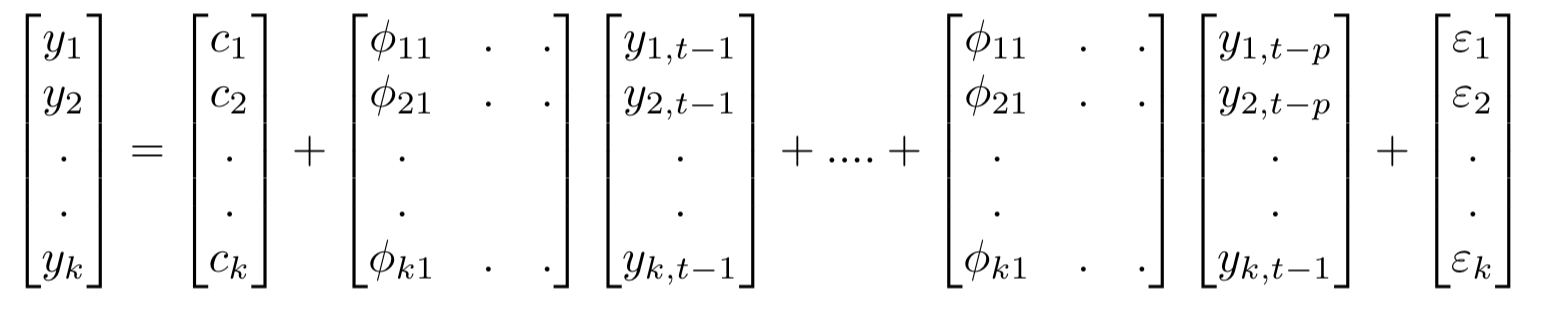

In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,Trieu USD/ Nghin tan
date,,
2009-01-01,24000.0,1.535102
2009-01-02,24500.0,1.535102
2009-01-03,24500.0,1.535102
2009-01-04,24500.0,1.535102
2009-01-05,25000.0,1.535102


<Axes: >

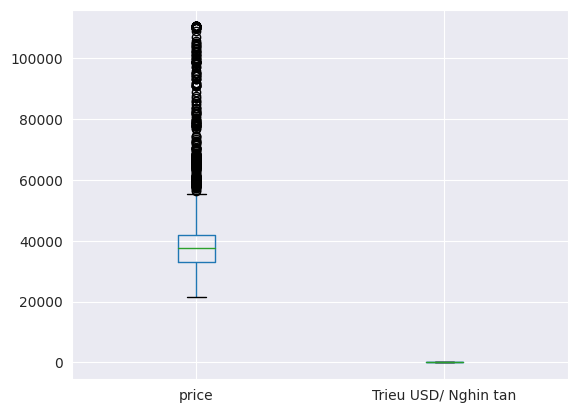

In [7]:
df.boxplot()

In [8]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 377


<Axes: >

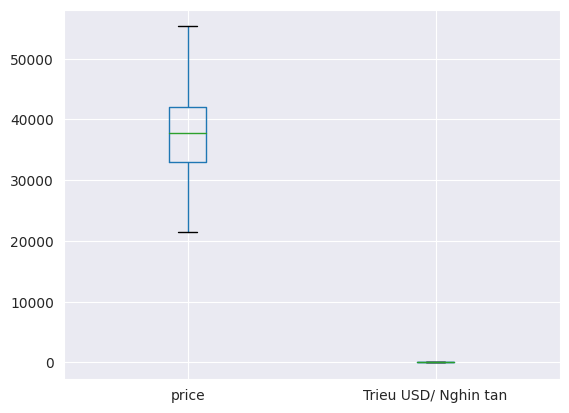

In [9]:
df.boxplot()

In [10]:
df = df.dropna()

In [11]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,Trieu USD/ Nghin tan
price,1.000000,0.961501
Trieu USD/ Nghin tan,0.961501,1.000000


In [12]:
df = df.rename(columns={'Trieu USD/ Nghin tan': 'xuat_khau'})

In [13]:
fillter_feature = ['price', 'xuat_khau']
df = df[fillter_feature]

In [14]:
from google.colab import files
df.to_csv('./gia_cafe_xuat_khau.csv')
files.download('./gia_cafe_xuat_khau.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,xuat_khau
price,1.000000,0.961501
xuat_khau,0.961501,1.000000


<Axes: xlabel='date'>

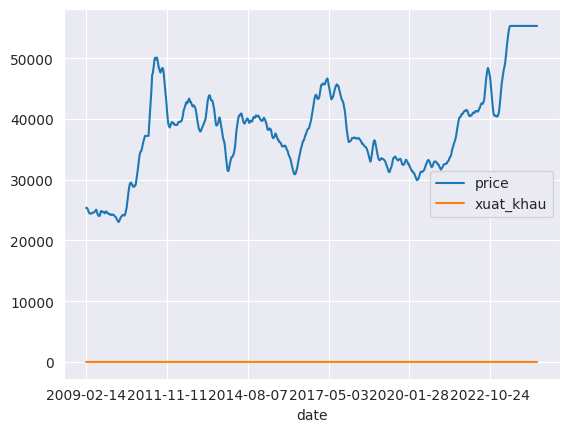

In [16]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

In [17]:
nobs = int(len(df) * 0.7)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(3906, 2)
(1675, 2)


In [18]:
from google.colab import files


## Kiểm tra stationary

In [19]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [20]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.632
 No. Lags Chosen       = 4
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0866. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "xuat_khau" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1312
 No. Lags Chosen       = 18
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0243. Rejecting Null Hypothesis.
 => Series is Stationary.




In [21]:
df_differenced = df_train.diff().dropna()

In [22]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1704
 No. Lags Chosen       = 3
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "xuat_khau" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6597
 No. Lags Chosen       = 17
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.




## Train model

In [23]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -10.506571156894832
BIC :  -10.49693525994678
FPE :  2.735609625057615e-05
HQIC:  -10.503151264111185 

Lag Order = 2
AIC :  -10.505647704434462
BIC :  -10.489584417816014
FPE :  2.738137003289819e-05
HQIC:  -10.499946581500883 

Lag Order = 3
AIC :  -10.504180429571225
BIC :  -10.481686984338893
FPE :  2.742157565212435e-05
HQIC:  -10.49619703431554 

Lag Order = 4
AIC :  -10.512966913103295
BIC :  -10.484040538386267
FPE :  2.718169207592776e-05
HQIC:  -10.502700202606654 

Lag Order = 5
AIC :  -10.511554531739225
BIC :  -10.476192454737536
FPE :  2.7220110484005137e-05
HQIC:  -10.499003462335377 

Lag Order = 6
AIC :  -10.510445092805217
BIC :  -10.468644538787892
FPE :  2.7250326824040695e-05
HQIC:  -10.49560862007978 

Lag Order = 7
AIC :  -10.508817114507352
BIC :  -10.46057530681058
FPE :  2.7294726620155212e-05
HQIC:  -10.49169419329709 

Lag Order = 8
AIC :  -10.508162452949145
BIC :  -10.453476612974416
FPE :  2.7312602226699707e-05
HQIC:  -10.48875203734

In [24]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-4.707,-4.703,0.009035,-4.705
1,-10.49,-10.48,2.771e-05,-10.49
2,-10.49,-10.48,2.773e-05,-10.49
3,-10.49,-10.47,2.776e-05,-10.48
4,-10.50,-10.47,2.751e-05,-10.49
5,-10.50,-10.46,2.755e-05,-10.49
6,-10.50,-10.46,2.757e-05,-10.48
7,-10.50,-10.45,2.761e-05,-10.48
8,-10.50,-10.44,2.762e-05,-10.48
9,-10.50,-10.43,2.764e-05,-10.47


In [25]:
model_var = model.fit(47)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     08:55:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.8824
Nobs:                     3858.00    HQIC:                  -11.0812
Log likelihood:           10828.1    FPE:                1.38035e-05
AIC:                     -11.1906    Det(Omega_mle):     1.31480e-05
--------------------------------------------------------------------
Results for equation price
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.021387         0.189390            0.113           0.910
L1.price              0.922944         0.016309           56.592           0.000
L1.xuat_khau        585.643076       620.399670            0

In [26]:
def adjust(val, length= 6): return str(val).ljust(length)

In [27]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.0
xuat_khau : 2.0


In [28]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

47


array([[-8.88888889e+00,  2.45497713e-03],
       [ 4.44444444e+00,  2.45497713e-03],
       [ 1.55555556e+01,  2.45497713e-03],
       [ 2.00000000e+01,  2.45497713e-03],
       [ 6.66666667e+00,  2.45497713e-03],
       [ 2.22222222e+00,  2.45497713e-03],
       [ 6.66666667e+00,  2.21791556e-03],
       [ 1.77777778e+01,  2.21791556e-03],
       [ 1.77777778e+01,  2.21791556e-03],
       [ 1.11111111e+01,  2.21791556e-03],
       [ 1.55555556e+01,  2.21791556e-03],
       [ 1.55555556e+01,  2.21791556e-03],
       [ 1.33333333e+01,  2.21791556e-03],
       [ 1.55555556e+01,  2.21791556e-03],
       [ 1.11111111e+01,  2.21791556e-03],
       [ 2.00000000e+01,  2.21791556e-03],
       [ 2.00000000e+01,  2.21791556e-03],
       [ 1.55555556e+01,  2.21791556e-03],
       [ 2.66666667e+01,  2.21791556e-03],
       [ 1.11111111e+01,  2.21791556e-03],
       [ 8.88888889e+00,  2.21791556e-03],
       [ 2.22222222e+00,  2.21791556e-03],
       [ 8.88888889e+00,  1.64614873e-03],
       [ 4.

In [29]:
import joblib
joblib.dump(model_var, 'var_gia_lua.joblib')

['var_gia_lua.joblib']

In [30]:
from google.colab import files
files.download('var_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,xuat_khau_2d
date,,
2019-10-26,-54.951013,-0.000597
2019-10-27,-55.630507,-0.000634
2019-10-28,-46.496483,-0.000691
2019-10-29,-45.535331,-0.000742
2019-10-30,-46.917786,-0.000575
...,...,...
2024-05-25,1.677347,0.000074
2024-05-26,1.677346,0.000074
2024-05-27,1.677341,0.000074


In [32]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [33]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2019-10-26,32800.604543
2019-10-27,32744.974035
2019-10-28,32698.477552
2019-10-29,32652.942221
2019-10-30,32606.024435
...,...
2024-05-25,33332.459097
2024-05-26,33334.136442
2024-05-27,33335.813783


### Đánh giá mô hình VAR

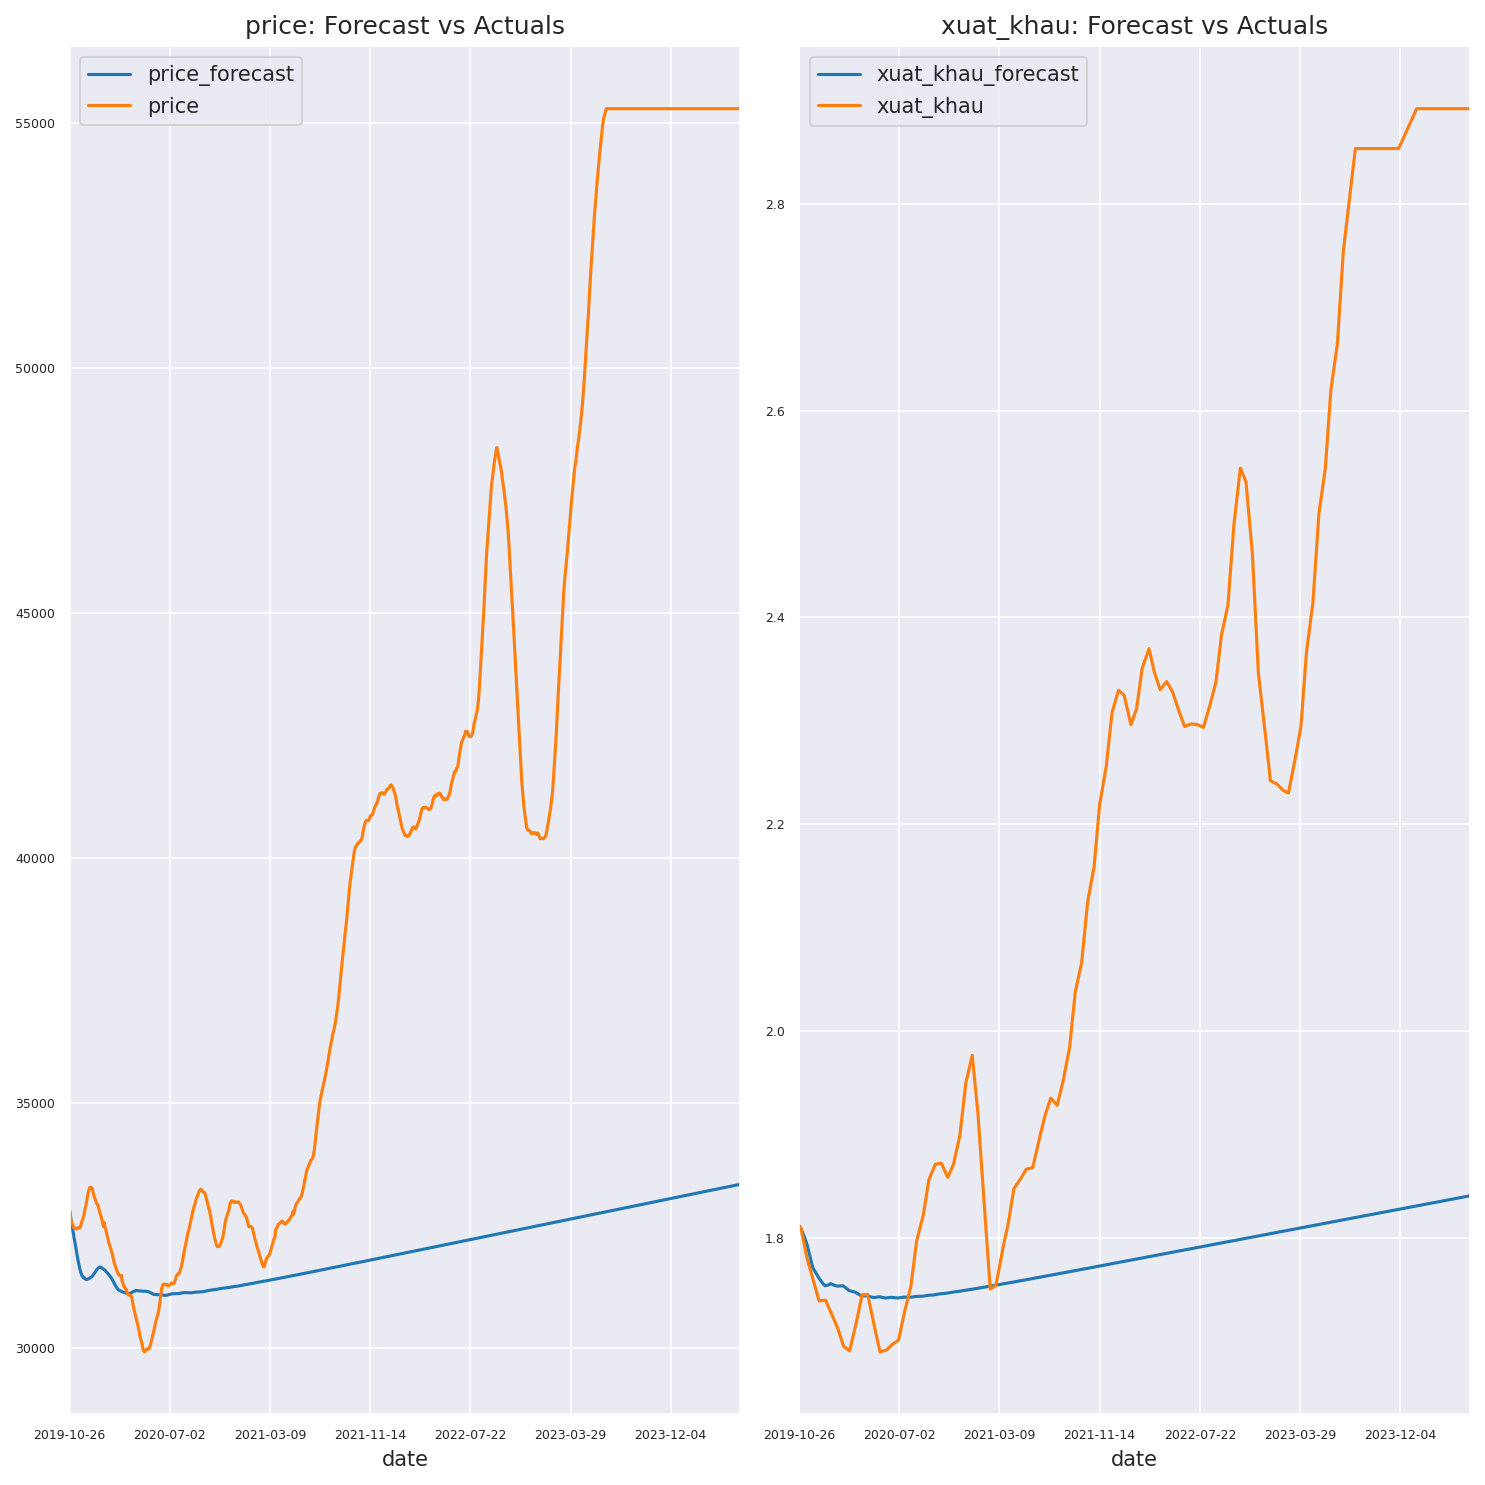

In [34]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [35]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [36]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  19.6434
rmse   :  12453.9175


## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [37]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00


In [38]:
from pmdarima import auto_arima

In [39]:
columns_train = fillter_feature

In [40]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31749.246, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31761.253, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31751.927, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31750.911, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31759.259, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31747.385, Time=6.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31746.446, Time=1.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31747.313, Time=1.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31749.243, Time=8.33 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=31744.453, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31749.933, Time=0.34 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=31745.320, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31745.392, Time=1.72 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=31747

In [41]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [42]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [43]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df_train[columns_train], result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

        print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


Grid Search Started
 Running for (2, 1, 0)
{'p': 2, 'q': 0, 'RMSE Open': 294.70820527714625}


In [44]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(3,2),trends = 'n').fit( disp=False)


In [45]:
result = model_varma.forecast(len(df_test))

In [46]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [47]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  19.2564
rmse   :  12256.301


In [48]:
inv_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1675 entries, 2019-10-26 to 2024-05-26
Freq: D
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               1675 non-null   float64
 1   xuat_khau           1675 non-null   float64
 2   price_forecast      1675 non-null   float64
 3   xuat_khau_forecast  1675 non-null   float64
dtypes: float64(4)
memory usage: 65.4 KB


In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1675 entries, 2019-10-26 to 2024-05-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      1675 non-null   float64
 1   xuat_khau  1675 non-null   float64
dtypes: float64(2)
memory usage: 39.3+ KB


In [50]:
inv_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1675 entries, 2019-10-26 to 2024-05-26
Freq: D
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               1675 non-null   float64
 1   xuat_khau           1675 non-null   float64
 2   price_forecast      1675 non-null   float64
 3   xuat_khau_forecast  1675 non-null   float64
dtypes: float64(4)
memory usage: 65.4 KB


In [51]:
df_test.index = pd.to_datetime(df_test.index)
df_train.index = pd.to_datetime(df_train.index)


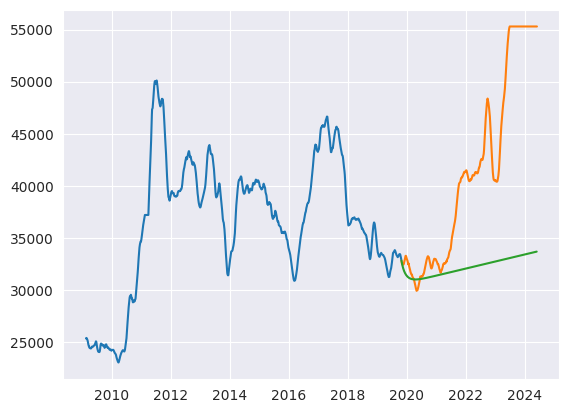

In [52]:
import matplotlib.pyplot as plt

plt.plot(df_train.price)
plt.plot(df_test.price)
plt.plot(inv_res.price_forecast)

plt.show()

In [53]:
import joblib
from google.colab import drive

drive.mount('/content/drive')
var_file_name = 'var_gia_cafe_xuat_khau.joblib'
varma_file_name = 'varma_gia_cafe_xuat_khau.joblib'

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

Mounted at /content/drive


['/content/drive/MyDrive/model/var_gia_cafe_xuat_khau.joblib']